In [1]:
import pandas as pd
import numpy as np
#import spacy
import nltk
from ast import literal_eval
from HanTa import HanoverTagger as ht
from tqdm.auto import tqdm
from collections import Counter
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from typing import List
import re
import pickle
import mgzip
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Sentiment classification of comments

## Lexicon approach

In [2]:
# load command
with mgzip.open('../data/combined_comments_pre.mgzip', 'rb') as handle:
    combined_comments_pre = pickle.load(handle)

In [3]:
combined_comments_pre = combined_comments_pre.reset_index()

In [4]:
senti_merge = pd.read_csv('../resources/sentimerge/data/sentimerge.txt', sep='\t')
senti_merge.drop(['PoS'], axis=1, inplace=True)

In [5]:
senti_merge_pos = senti_merge.loc[senti_merge['sentiment'] > 0]
senti_merge_neg = senti_merge.loc[senti_merge['sentiment'] < 0]

In [6]:
senti_pos_dict = dict(zip(senti_merge_pos['lemma'], senti_merge_pos['sentiment']))
senti_neg_dict = dict(zip(senti_merge_neg['lemma'], senti_merge_neg['sentiment']))
senti_weight_dict = dict(zip(senti_merge['lemma'], senti_merge['weight']))

negation checker inspired by HD students not worth it (https://github.com/text-analytics-20/news-sentiment-development/blob/main/sentiment_analysis/negation_handling.py)

In [7]:
def senti_class(input):
    tmp_list = []
    for word in input:
        if not word:
            continue
        if str(word).lower() in senti_pos_dict:
            tmp_list.append((senti_pos_dict[word.lower()]*senti_weight_dict[word.lower()]))
        if str(word).lower() in senti_neg_dict:
            tmp_list.append((senti_neg_dict[word.lower()]*senti_weight_dict[word.lower()]))
    if not tmp_list:
        return np.nan
    return sum(tmp_list)

In [8]:
def rescale_neg(input):
    return (2 *(input - min(input))/(max(input)-min(input))) - 1

In [9]:
def rescale(input):
    scale = input
    scale -= scale.min()
    scale /= scale.max()
    return scale

In [10]:
def lexi_label(input):
    if input > 1:
        return 'positive'
    elif input < -1:
        return 'negative'
    elif pd.isna(input):
        return np.nan
    else:
        return 'neutral'

In [36]:
combined_comments_pre['lexi_score'] = combined_comments_pre['tokens'].progress_apply(senti_class)

  0%|          | 0/1772864 [00:00<?, ?it/s]

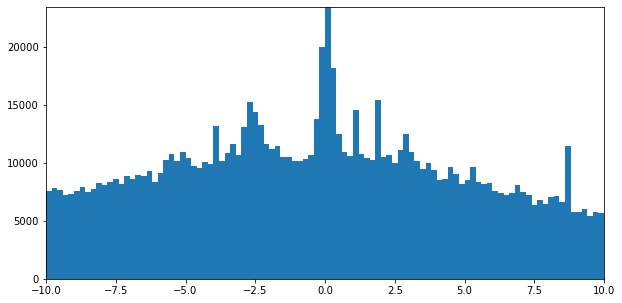

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.margins(0)
plt.hist(combined_comments_pre["lexi_score"].loc[(combined_comments_pre['lexi_score'] > -10) | (combined_comments_pre['lexi_score'] < 10)], bins=100, range=(-10,10))
plt.savefig('../figures/lexi_neutral.png')

In [37]:
combined_comments_pre['lexi_label'] = combined_comments_pre['lexi_score'].apply(lexi_label)

In [38]:
combined_comments_pre['lexi_conf'] = rescale(combined_comments_pre['lexi_score'])

In [39]:
combined_comments_pre['lexi_score'] = combined_comments_pre['tokens'].progress_apply(senti_class)

  0%|          | 0/1772864 [00:00<?, ?it/s]

In [40]:
combined_comments_pre['lexi_score'] = rescale_neg(combined_comments_pre['lexi_score'])

In [41]:
combined_comments_lexi = combined_comments_pre[['title', 'value', 'newspaper', 'lexi_score', 'lexi_label', 'lexi_conf']]

## BERT approach
This step was calculated on Google Colab cloud due to taking way too long on my laptop.

In [56]:
class SentimentModel():
    def __init__(self, model_name: str):
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)
        self.clean_http_urls = re.compile(r'https*\\S+', re.MULTILINE)
        self.clean_at_mentions = re.compile(r'@\\S+', re.MULTILINE)

    @staticmethod
    def probs2polarities(pnn: torch.Tensor) -> torch.Tensor:
        """Transform softmax probs of a [positive, negative, neutral] classifier
        into scalar polarity scores of range [-1, 1].
        High values express positive sentiment, low negative ones negative sentiment.
        Values close to 0 express neutral sentiment."""
        pos = pnn[:, 0]
        neg = pnn[:, 1]
        # Transform range [0, 1] to [-1, 1]
        # Ignore neutrality score as it's implicitly encoded as (1 - pos - neg)
        polarities = pos - neg
        return polarities

    def predict_sentiment(self, texts):
        if np.any(pd.isna(texts)):
          return np.nan
        texts = [self.clean_text(str(text)) for text in [texts]]
        # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
        encoded = self.tokenizer.batch_encode_plus(texts,padding=True, add_special_tokens=True,truncation=True, return_tensors="pt")
        encoded = encoded.to(self.device)
        with torch.no_grad():
                logits = self.model(**encoded)
                probs = torch.nn.functional.softmax(logits[0], dim=1)

        polarities = self.probs2polarities(probs)

        label_ids = torch.argmax(logits[0], axis=1)
        for a in zip(logits[0].tolist(), [self.model.config.id2label[label_id] for label_id in label_ids.tolist()]):
            tmp_rsl = list(a)
        return tmp_rsl, polarities.item()

    def replace_numbers(self,text: str) -> str:
            return text.replace("0"," null").replace("1"," eins").replace("2"," zwei").replace("3"," drei").replace("4"," vier").replace("5"," fünf").replace("6"," sechs").replace("7"," sieben").replace("8"," acht").replace("9"," neun")

    def clean_text(self,text: str)-> str:
            text = text.replace("\n", " ")
            text = self.clean_http_urls.sub('',text)
            text = self.clean_at_mentions.sub('',text)
            text = self.replace_numbers(text)
            text = self.clean_chars.sub('', text) # use only text chars
            text = ' '.join(text.split()) # substitute multiple whitespace with single whitespace
            text = text.strip().lower()
            return text

In [57]:
# oliverguhr/german-sentiment-bert
model = SentimentModel(model_name = "mdraw/german-news-sentiment-bert")

In [ ]:
combined_comments_pre['bert'] = combined_comments_pre['value'].progress_apply(model.predict_sentiment)

In [58]:
def bert_score(input):
    return np.ptp(sorted(list(map(abs, input[0][0]))))

def bert_label(input):
    return input[0][1]

def bert_props(input):
    return input[1]

In [100]:
combined_comments_pre['bert_conf'] = combined_comments_pre['bert'].apply(bert_score)

In [101]:
combined_comments_pre['bert_label'] = combined_comments_pre['bert'].apply(bert_label)

In [102]:
combined_comments_pre['bert_score'] = combined_comments_pre['bert'].apply(bert_props)

In [ ]:
combined_comments_bert = combined_comments_pre[['title', 'bert_score', 'bert_label']]

In [48]:
combined_comments_bert['bert_conf'] = rescale(combined_comments_bert['bert_conf'])

Load file that was produced on Google Colab

In [15]:
with mgzip.open('../data/combined_comments_bert.mgzip', 'rb') as handle:
    combined_comments_bert = pickle.load(handle)

## Combine lexi & bert

In [16]:
combined_comments_bert = combined_comments_bert.reset_index()

In [31]:
combined_comments_bert['bert_conf'] = rescale(combined_comments_bert['bert_conf'])

In [42]:
combined_comments_senti = pd.DataFrame()

In [43]:
combined_comments_senti[['title', 'value', 'newspaper', 'lexi_score', 'lexi_label', 'lexi_conf']] = combined_comments_lexi

In [44]:
combined_comments_senti[['bert_score', 'bert_label', 'bert_conf']] = combined_comments_bert[['bert_score', 'bert_label', 'bert_conf']]

In [45]:
combined_comments_senti

,title,value,newspaper,lexi_score,lexi_label,lexi_conf,bert_score,bert_label,bert_conf
0,"Handel: ""Viele brauchen ja eigentlich nichts m...","\nSehr schönes Interview, Danke!\nEs ist eben ...",zeit,0.212949,positive,0.606474,0.166603,neutral,0.197398
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,\nHome Office wo und wann immer möglich UND fa...,zeit,0.432443,positive,0.716222,0.996023,positive,0.395625
2,Coronavirus: RKI registriert erstmals wieder l...,\nWie ich es voraus gesagt habe.\nEs zeichnete...,zeit,0.163391,positive,0.581695,0.816437,positive,0.561593
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,\nEntfernt. Bitte verzichten Sie auf Unterstel...,zeit,0.137010,positive,0.568505,-0.975590,negative,0.323397
4,Corona-Impfung für Kinder: Gesundheitsminister...,\nWarum schafft man eigentlich nicht endlich d...,zeit,0.079517,negative,0.539759,-0.988513,negative,0.397976
...,...,...,...,...,...,...,...,...,...
1772859,Inzidenz in Berlin steigt wieder leicht,"Nach allem, was man hinsichtlich der Entwicklu...",tagespiegel,0.061895,negative,0.530947,-0.960944,negative,0.246601
1772860,Inzidenz in Berlin steigt wieder leicht,"Man kann nur hoffen,daß dem Berliner Senat mög...",tagespiegel,0.137527,positive,0.568764,-0.970524,negative,0.233392
1772861,Inzidenz in Berlin steigt wieder leicht,Massentest bringen natürlich etwas: Die Verlau...,tagespiegel,-0.017365,negative,0.491317,-0.903010,negative,0.187466
1772862,Inzidenz in Berlin steigt wieder leicht,"Wenn schon Shutdown, dann richtig. Dann ist di...",tagespiegel,0.093103,negative,0.546551,-0.982647,negative,0.306953


In [46]:
with mgzip.open('../data/combined_comments_senti.mgzip', 'wb') as handle:
    pickle.dump(combined_comments_senti, handle)

In [3]:
with mgzip.open('../data/combined_comments_senti.mgzip', 'rb') as handle:
    combined_comments_senti = pickle.load(handle)

construct majority vote

In [47]:
combined_comments_senti['vote'] = np.where((combined_comments_senti['lexi_score'] > combined_comments_senti['bert_score']), 'lexi', 'bert')
combined_comments_senti['vote_score'] = np.where((combined_comments_senti['lexi_score'] > combined_comments_senti['bert_score']), combined_comments_senti['lexi_score'], combined_comments_senti['bert_score'])
combined_comments_senti['vote_label'] = np.where((combined_comments_senti['lexi_score'] > combined_comments_senti['bert_score']), combined_comments_senti['lexi_label'], combined_comments_senti['bert_label'])

Group on title to get average score per articles

In [60]:
combined_comments_group = combined_comments_senti.groupby(['title', 'newspaper'], as_index = False)['lexi_score', 'bert_score', 'vote_score', 'bert_label'].agg(lexi_score = ('lexi_score', np.mean), bert_score=('bert_score', np.mean), vote_score=('vote_score', np.mean), bert_label=('bert_label', lambda x: pd.Series.mode(x)[0]), count=('bert_label', np.count_nonzero))

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_8619/2367114319.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  combined_comments_group = combined_comments_senti.groupby(['title', 'newspaper'], as_index = False)['lexi_score', 'bert_score', 'vote_score', 'bert_label'].agg(lexi_score = ('lexi_score', np.mean), bert_score=('bert_score', np.mean), vote_score=('vote_score', np.mean), bert_label=('bert_label', lambda x: pd.Series.mode(x)[0]), count=('bert_label', np.count_nonzero))


In [61]:
with mgzip.open('../data/combined_comments_group.mgzip', 'wb') as handle:
    pickle.dump(combined_comments_group, handle)

# Test both methods on test data

In [108]:
with mgzip.open('../data/test_data.mgzip', 'rb') as handle:
    test_data = pickle.load(handle)

In [126]:
test_data

,title,date,variable,value,newspaper,tokens,labels,test_score,lexi_score,lexi_conf,bert,bert_score,bert_conf,vote_score
1076212,"Testen, Impfen, mehr Kontrolle – Spahns Plan f...",2021-03-11 11:53:00,Comment146,„Bettenauslastung auf Intensivstationen: Da di...,welt,"[bettenauslastung, intensivstation, anzahl, in...",negative,-1,0.029541,0.514770,"([[-1.2487313747406006, 1.2091127634048462, 1....",-0.464285,0.021429,0.029541
4124113,"""Alternativlos"" – Divi spricht sich offiziell ...",2021-11-25 11:47:00,Comment562,Man lasse sich seine Forderung nach der Impfpf...,welt,"[lassen, forderung, impfpflicht, zunge, zergeh...",negative,-1,-0.282620,0.358690,"([[-2.009507656097412, 2.3299968242645264, 0.4...",-0.847685,0.323672,-0.282620
1552045,"""Wir impfen Deutschland zurück in die Freiheit""",2021-08-24 13:37:00,Comment211,„Wir impfen Deutschland zurück in die Freiheit...,welt,"[impfen, deutschland, freiheit, ganz, sicher, ...",negative,-1,-0.144016,0.427992,"([[-0.7984168529510498, 0.7045993804931641, 0....",-0.339992,0.009290,-0.144016
1313855,"Mehrheit der Deutschen für Testpflicht, aber g...",2020-06-08 18:00:00,Comment179,"Wer Geld für Urlaub in Risikogebieten hat, ka...",welt,"[geld, urlaub, risikogebiet, sicher, test, lei...",negative,-1,-0.215824,0.392088,"([[-1.0484485626220703, 1.5324848890304565, -0...",-0.769513,0.166087,-0.215824
53410,Wandergruppe löst Corona-Ausbruch in Baden-Wür...,2021-02-04 15:41:00,Comment4,"Nein, eine ""Hexenjagd"" darf es nicht geben, ab...",tagespiegel,"[nein, hexenjagd, dürfen, nicht, geben, verurt...",neutral,0,-0.188929,0.405535,"([[-1.6874444484710693, 1.9465515613555908, 0....",-0.782619,0.259968,-0.188929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666334,Dramatische Unzufriedenheit mit Corona-Politik...,2021-02-12 18:02:00,Comment363,Wo finden Sie so viele die für eine härtere Ga...,welt,"[finden, hart, gangart, nicht, glauben]",negative,-1,-0.151887,0.424056,"([[-0.7616156339645386, 0.8662086725234985, -0...",-0.512742,0.122612,-0.151887
3564864,Merkel wirbt bei Familien um Geduld in Corona-...,2021-01-30 11:04:00,Comment486,"Ich verstehe es nur als absolute Chuzpe, dass ...",welt,"[verstehen, nur, absolut, chuzpe, frau, wagen,...",negative,-1,0.058065,0.529032,"([[0.3681217432022095, -0.44754230976104736, 0...",0.193823,0.056089,0.058065
11691107,Bundesregierung plant ab Herbst weitergehende ...,2021-03-08 20:30:00,Comment1595,"Die Schikanen überzeugen mich leider nicht, nm...",welt,"[schikanen, überzeugen, leider, nicht, nmch, i...",negative,-1,-0.221797,0.389101,"([[2.3563437461853027, 0.15069039165973663, -2...",0.797486,0.461725,0.797486
266383,Die Reise im Flugzeug ist nur noch eine reine ...,2020-08-24 18:09:00,Comment36,Wir haben in den schwerer betroffenen Bundeslä...,welt,"[schwer, betroffen, bundesland, inzidenz, 15, ...",neutral,0,-0.107408,0.446296,"([[-0.6292436122894287, 0.26691189408302307, 1...",-0.146739,0.161908,-0.107408


In [110]:
test_data['test_score'] = np.where(test_data['labels'] == 'negative', -1, np.where(test_data['labels'] == 'neutral', 0, 1))

In [115]:
test_data['lexi_score'] = test_data['tokens'].apply(senti_class)

In [113]:
test_data['lexi_conf'] = rescale(test_data['lexi_score'])

In [117]:
test_data['lexi_score'] = rescale_neg(test_data['lexi_score'])

In [ ]:
test_data['bert'] = test_data['value'].progress_apply(model.predict_sentiment)

In [120]:
test_data['bert_score'] = test_data['bert'].apply(bert_props)

In [121]:
test_data['bert_conf'] = test_data['bert'].apply(bert_score)

In [123]:
test_data['bert_conf'] = rescale(test_data['bert_conf'])

In [125]:
test_data['vote_score'] = np.where((test_data['lexi_conf'] > test_data['bert_conf']), test_data['lexi_score'], test_data['bert_score'])

In [127]:
test_data['mae_bert'] = abs(abs(test_data['test_score']) - abs(test_data['bert_score']))

In [128]:
test_data['mae_lexi'] = abs(abs(test_data['test_score']) - abs(test_data['lexi_score']))

In [129]:
test_data['mae_vote'] = abs(abs(test_data['test_score']) - abs(test_data['vote_score']))

In [137]:
test_data['mae_bert'].mean()

0.42355419900755803